# Python data visualization

This tutorial will first introduce the plotting functionality of Xarray which can enable you make a plot very quickly; then we talk about how to use cartopy to make publication quality maps.

In [1]:
# import packages we need
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib as mpl
from matplotlib import gridspec
from cartopy.util import add_cyclic_point
import cmaps

In [2]:
xr.set_options(display_style='html') # make the display_style of xarray more user friendly
%matplotlib inline
%config InlineBackend.figure_format = "retina" # make our figures look better 

____________
## 1. Quick plot functionality of Xarray
____________
xarray plotting functionality is a thin wrapper around the popular matplotlib library. 

In [3]:
# use the North American air temperature dataset in Xarray tutorial
airtemps = xr.tutorial.open_dataset("air_temperature")
airtemps

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

**One-dimensional plot**

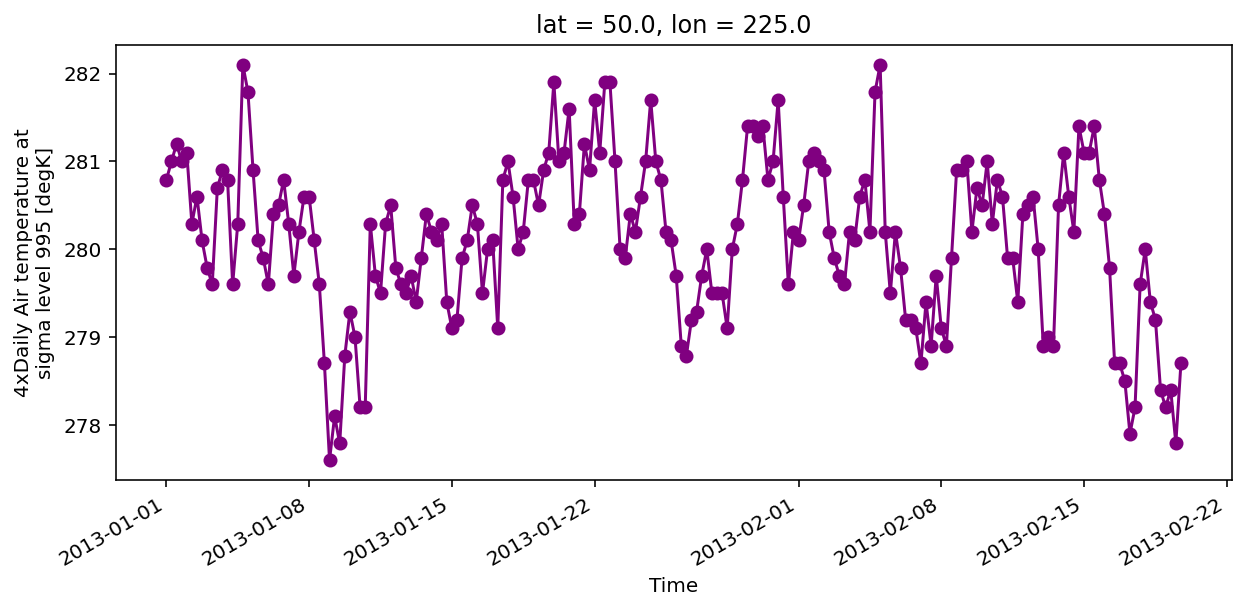

In [4]:
# labels can also be used to easily create informative plots
air1d = airtemps.air.isel(lat=10, lon=10)
air1d[:200].plot(color="purple", marker="o",figsize=(10,4))

**adding to existing axis**

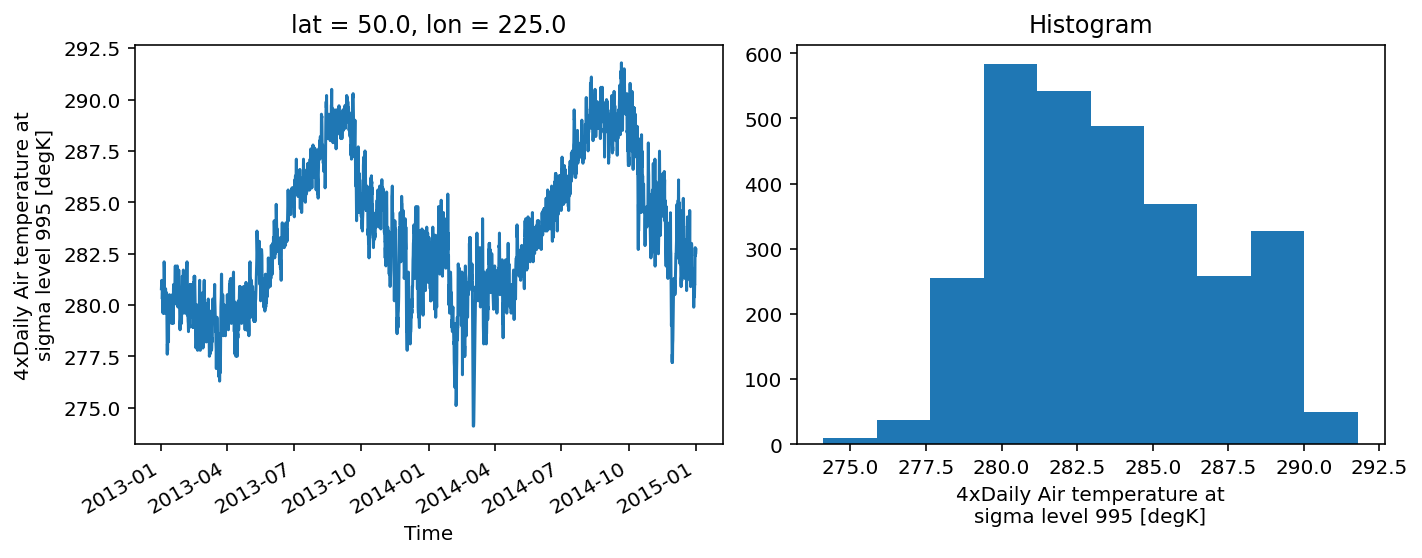

In [5]:
fig, axes = plt.subplots(ncols=2,figsize=(10,4))
air1d.plot(ax=axes[0])
air1d.plot.hist(ax=axes[1])
plt.tight_layout()
plt.draw()

**Multiple lines in one plot**

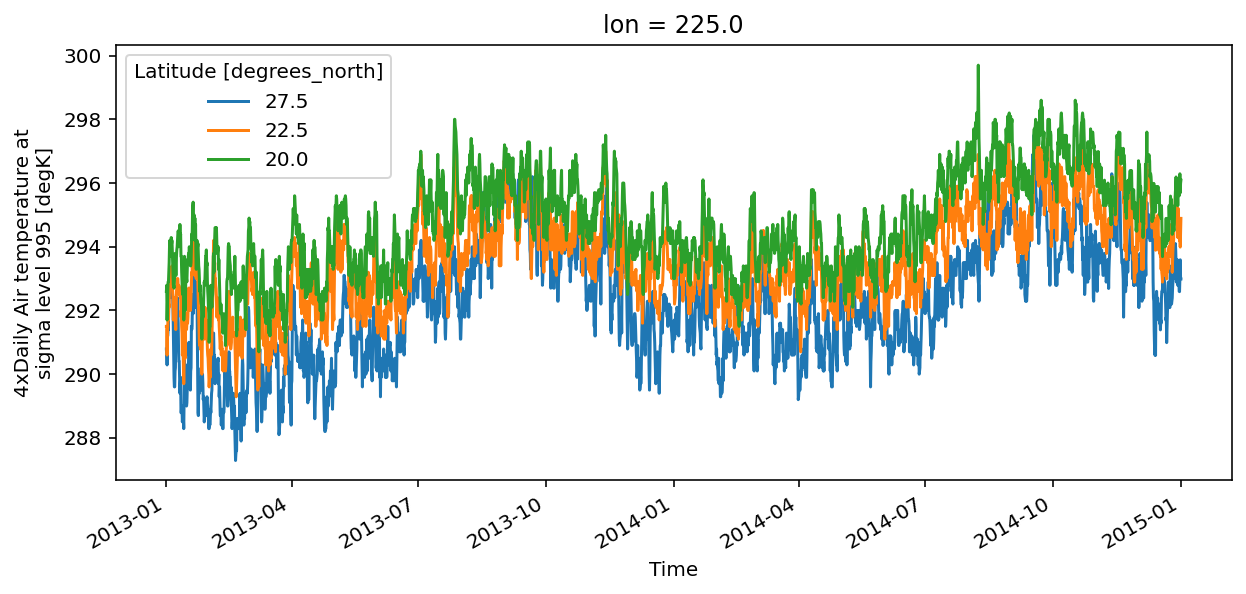

In [6]:
airtemps.air.isel(lon=10, lat=[19, 21, 22]).plot.line(x="time",figsize=(10,4))

**2-D map**

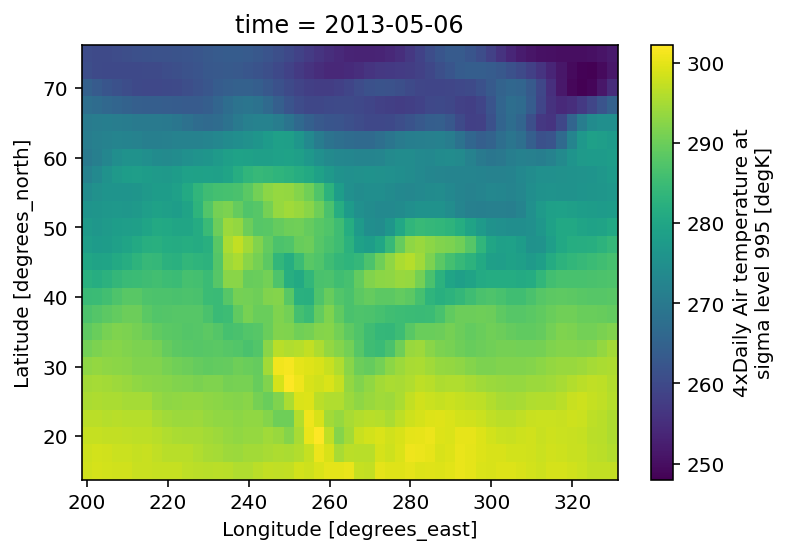

In [7]:
air2d = airtemps.air.isel(time=500)
air2d.plot()

**contour plot**

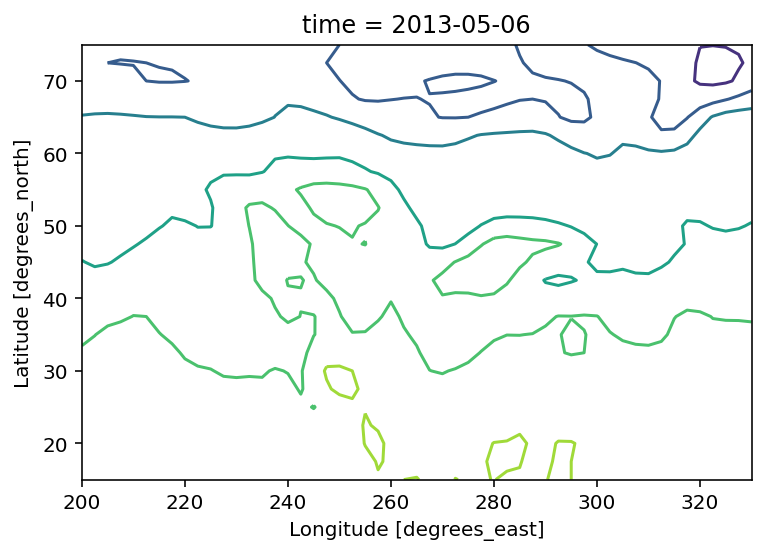

In [8]:
air2d.plot.contour()

**filled contour plot**

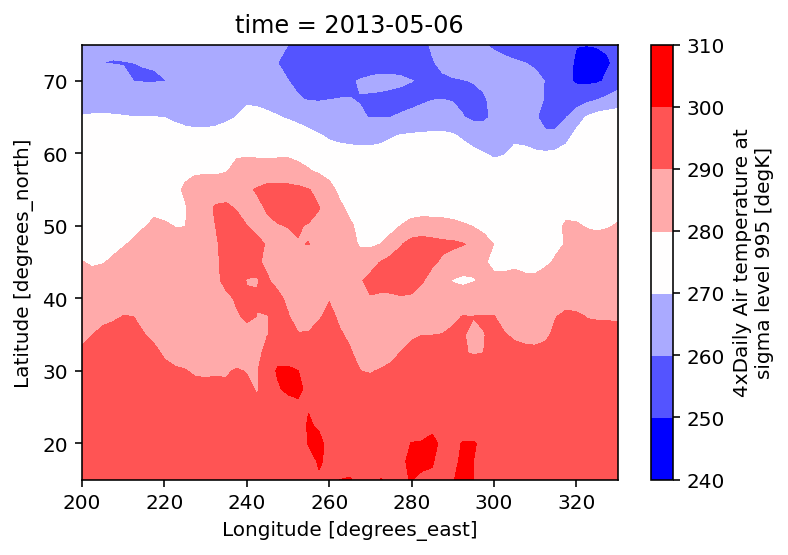

In [9]:
air2d.plot.contourf(cmap='bwr')

Text(0.5, 0, 'longitude')

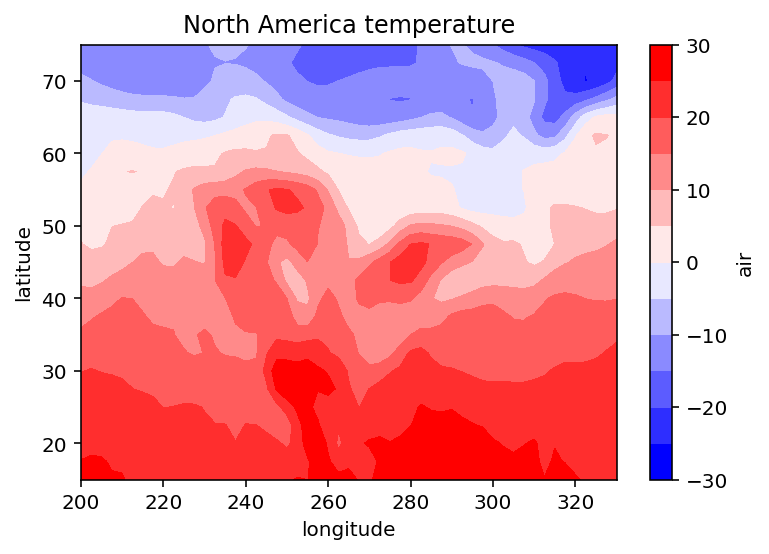

In [10]:
(air2d-273.15).plot.contourf(cmap='bwr',levels=np.arange(-30,30.1,5))
plt.title("North America temperature")
plt.ylabel("latitude")
plt.xlabel("longitude")

**Faceting**

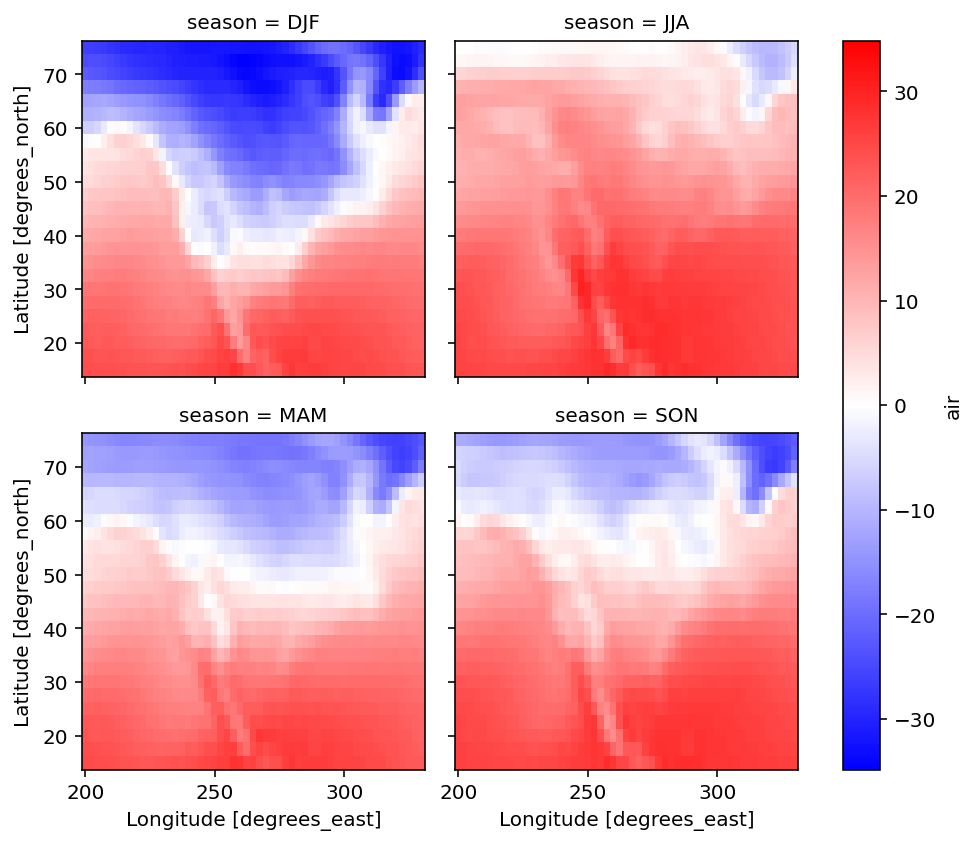

In [11]:
(airtemps.air-273.15).groupby('time.season').mean().plot(x="lon", y="lat", col="season", col_wrap=2,cmap='bwr')

Other types of plot that xarray supports: Streamplot, Quiver, Scatter; http://xarray.pydata.org/en/stable/user-guide/plotting.html

____________
## 2. Cartopy
____________
To start things off, we will introduce some basics of Cartopy to give you some ideas about what Cartopy can do!

### 2.1 Create a basic map projection using Cartopy
We create a basic map projection without using any real data. We will use the Cartopy feature interface (cfeature) to add some geographic features like ocean, lake, coastlines and borders. We will also add latitude and longitude gridlines.

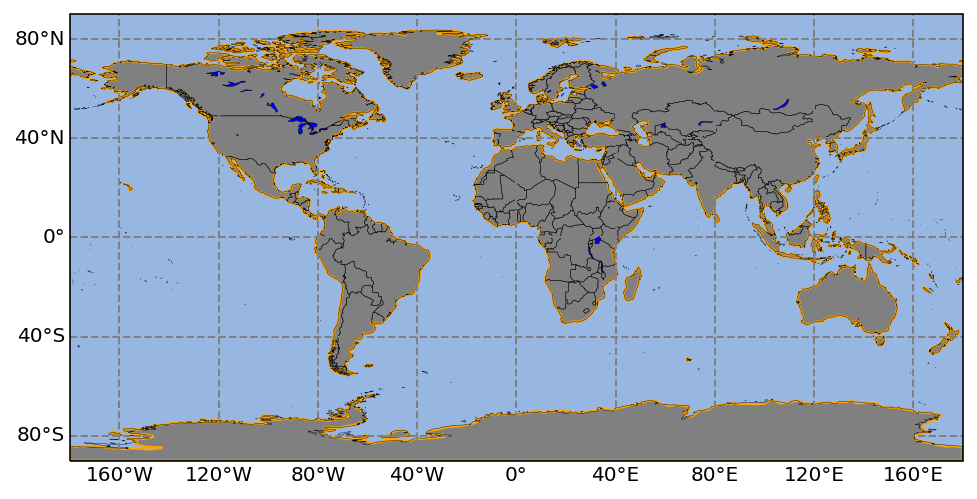

In [12]:
# Create and define the size of a figure object 
plt.figure(figsize=(8, 8))

# Create an axis with a basic PlateCarree projection style
# try different projection, e.g. Orthographic
ax = plt.axes(projection=ccrs.PlateCarree())

# A full list of cartopy map projections: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

# Add natural features to map using cartopy.feature (cfeature)
ax.add_feature(cfeature.LAND, edgecolor='orange', facecolor='grey', zorder=0) # Lower zorders will be drawn first.
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='blue')
ax.add_feature(cfeature.OCEAN)

# Add country border lines
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='50m', #1:50million; three options: 10m, 50m, 110m
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))


# Add lat/lon gridlines
# Draw gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='grey', draw_labels=True,linestyle='--')

# Manipulate latitude and longitude gridline numbers and spacing
gl.ylocator = mticker.FixedLocator(np.arange(-80,80.1,40))
gl.xlocator = mticker.FixedLocator(np.arange(-160, 160.1, 40))
# turn off gridline label on the top and right side
gl.top_labels = False
gl.right_labels = False

# For a list of available features in NaturalEarthFeature visit: https://www.naturalearthdata.com/features/

### 2.2 A map with data

In [13]:
# read in our output from data processing
diff=xr.open_dataset('./output.nc')

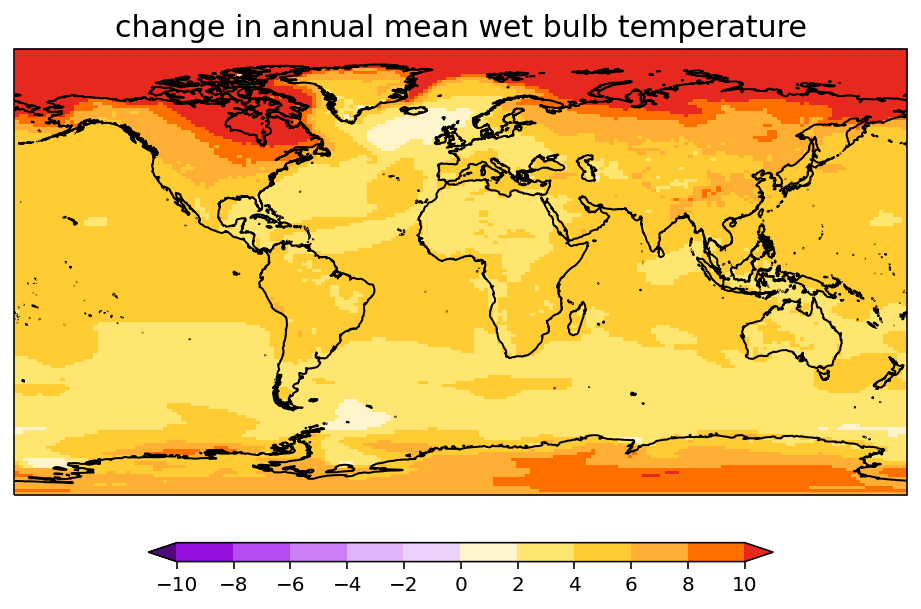

In [37]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree()) # Generate axes 
ax.coastlines('50m') # drawing coastlines
levels = np.arange(-10, 10.1, 2)
temp = diff.mean_diff.plot(ax=ax,
                      transform=ccrs.PlateCarree(), # What is the difference between 'transform' and 'projection'?
                      cmap=cmaps.sunshine_diff_12lev, # choose colormap
                       levels=levels, # discrete color bar
                      add_colorbar=False) # don't let xarray plot add colorbar automatically (which is the default)

# control color bar
cbar = plt.colorbar(temp,
                    orientation='horizontal', # control the orientation of color bar
                    shrink=0.7, # control the size of color bar relative to the axis
                    pad=0.073, # control the distance between color bar and the map
                    aspect=30, # control the width/height ratio of color bar
                    ticks=levels) # determine where to put the ticks
# control label size
cbar.ax.tick_params(labelsize=10)

# Add a title
plt.title('change in annual mean wet bulb temperature', fontsize=15)
plt.show()

### 2.3 What if we only want to plot data over land or certain area?

regionmask is a handy package to mask land, countries, or certain regions. Combining xarray (```xr.where(mask==*)```) and regionmask will make doing statistics over a certain region very easy.

In [15]:
import regionmask

land mask

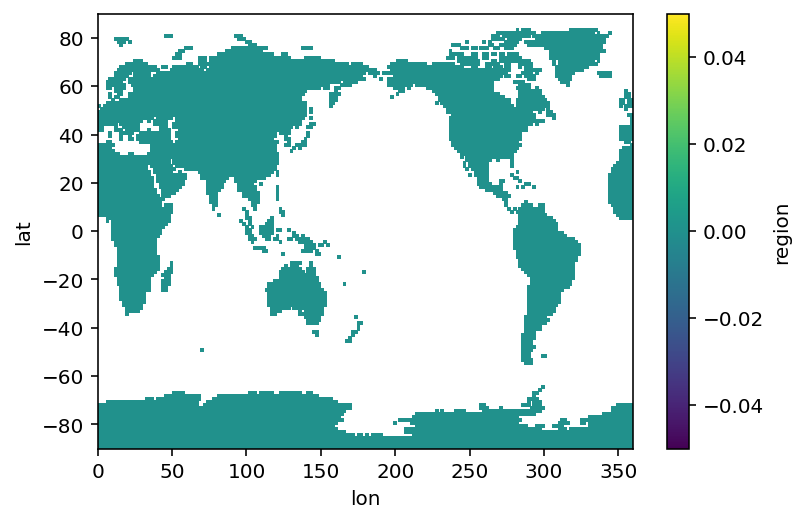

In [16]:
landmask= regionmask.defined_regions.natural_earth.land_110.mask(diff)
landmask.plot()

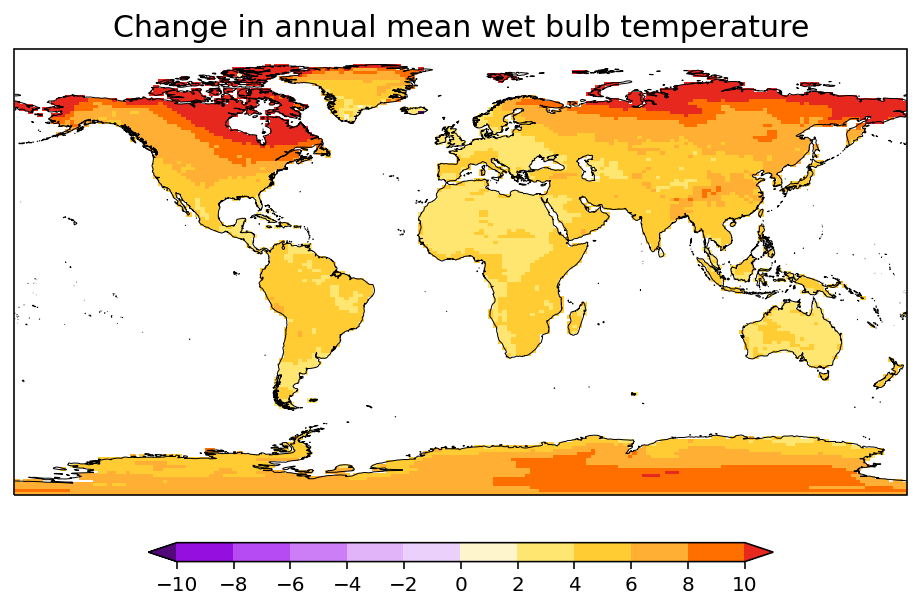

In [27]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m',linewidth=0.5)
levels = np.arange(-10, 10.1, 2)
temp = diff.mean_diff.where(landmask==0).plot(ax=ax,  # the only change happens here
                                          transform=ccrs.PlateCarree(),
                                          cmap=cmaps.sunshine_diff_12lev,
                                          levels=levels,
                                          add_colorbar=False)
cbar = plt.colorbar(temp,
                    orientation='horizontal',
                    shrink=0.7,
                    pad=0.073,
                    aspect=30,
                    ticks=levels)

cbar.ax.tick_params(labelsize=10)

plt.title('Change in annual mean wet bulb temperature', fontsize=15)
plt.show()

country mask

<GeoAxesSubplot:>

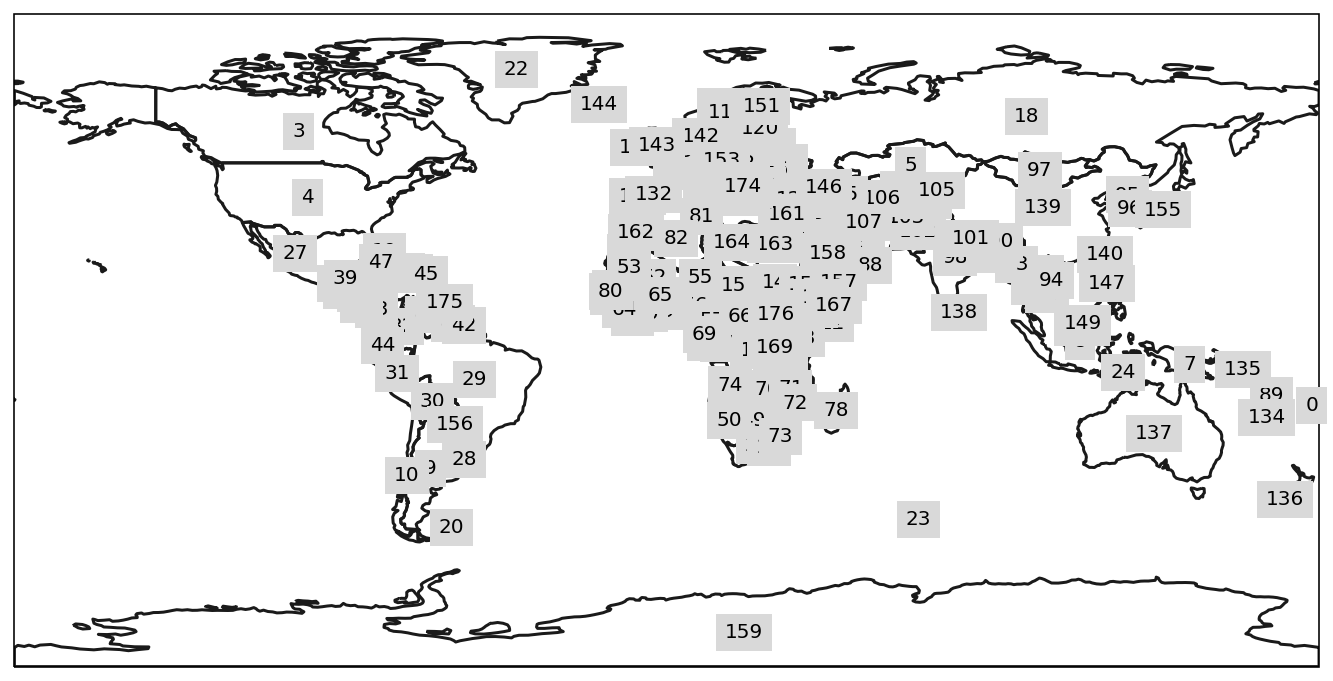

In [18]:
# show the country code
fig = plt.figure(figsize=(20,6))
regionmask.defined_regions.natural_earth.countries_110.plot()

In [19]:
countrymask=regionmask.defined_regions.natural_earth.countries_110.mask(diff,lon_name="lon", lat_name="lat")
# a xarray DataArray filled with country code
countrymask

<xarray.DataArray 'region' (lat: 144, lon: 192)>
array([[159., 159., 159., ..., 159., 159., 159.],
       [159., 159., 159., ..., 159., 159., 159.],
       [159., 159., 159., ..., 159., 159., 159.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

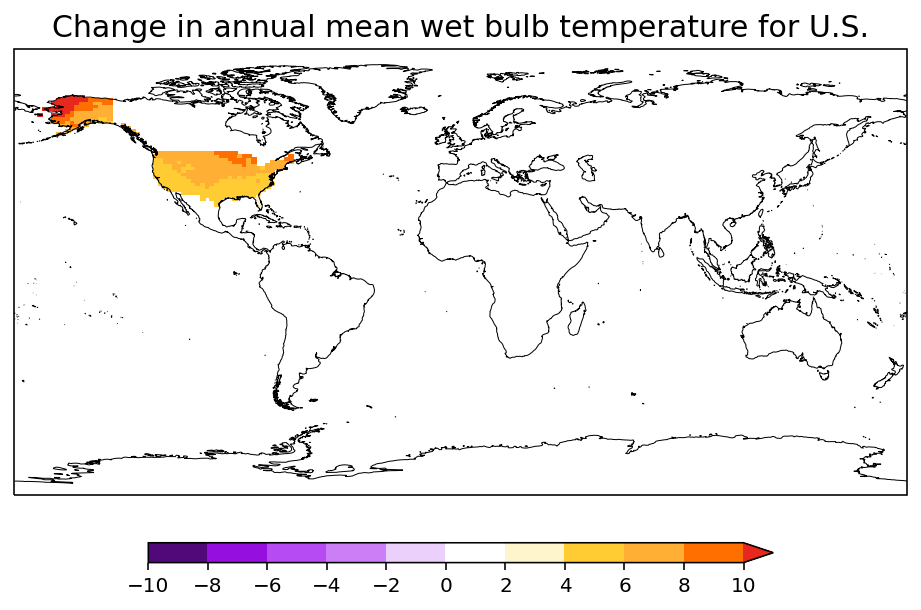

In [29]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m',linewidth=0.5)
levels = np.arange(-10, 10.1, 2)
temp = diff.mean_diff.where(countrymask==4).plot(ax=ax, # apply country mask
                                          transform=ccrs.PlateCarree(),
                                          cmap=cmaps.sunshine_diff_12lev,
                                          levels=levels,
                                          add_colorbar=False)
#ax.add_feature(cfeature.BORDERS,alpha=0.6) #add country border
#ax.set_extent([-170,-60,20,65]) # zoom in a certain area
cbar = plt.colorbar(temp,
                    orientation='horizontal',
                    shrink=0.7,
                    pad=0.073,
                    aspect=30,
                    ticks=levels)

cbar.ax.tick_params(labelsize=10)

plt.title('Change in annual mean wet bulb temperature for U.S.', fontsize=15)
plt.show()

An example of using regionmask to do statistics on a certain region: calculating land average temperature

In [21]:
diff.mean_diff.where(landmask==0).weighted(np.cos(np.deg2rad(diff.lat))).mean(('lat','lon'))

<xarray.DataArray 'mean_diff' ()>
array(5.58959167)

### 2.4 Multiple maps sharing the same colorbar

In [41]:
def subplot(data,axis,cmap,norm):
    g=data.where(landmask==0).plot(ax=axis,transform=ccrs.PlateCarree(),cmap=cmap,add_colorbar=False,norm=norm)
    axis.coastlines(linewidth=0.5)
    axis.set_title('')
    return g

def plot(diff):
    fig = plt.figure(figsize=[12, 5])
    ax0 = fig.add_subplot(121,projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(122,projection=ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0, left=0,right=1, top=1,hspace=0.1,wspace=0.05)
    
    anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    ax0.annotate('a. changes in annual mean wb', **anno_opts,fontsize=14)
    ax1.annotate('b. changes in annual q95 wb', **anno_opts,fontsize=14)
    
    cmap=cmaps.sunshine_diff_12lev
    levels=np.arange(-10, 10.1, 2)
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels)+1,extend='both') 
    # Generate a colormap index based on discrete intervals; 
    # colors are linearly distributed between these "bounds".
    
    # apply the same norm to both subplots which let them share the same color scale
    subplot(diff.mean_diff,ax0,cmap,norm)
    g=subplot(diff.q95_diff,ax1,cmap,norm)
    
    f=plt.gcf() #get the reference to the current figure
    cb=f.colorbar(g,ax=(ax0,ax1),orientation='horizontal', pad=0.05,shrink=0.5,ticks=levels,aspect=30) 
    cb.ax.tick_params(labelsize=12)

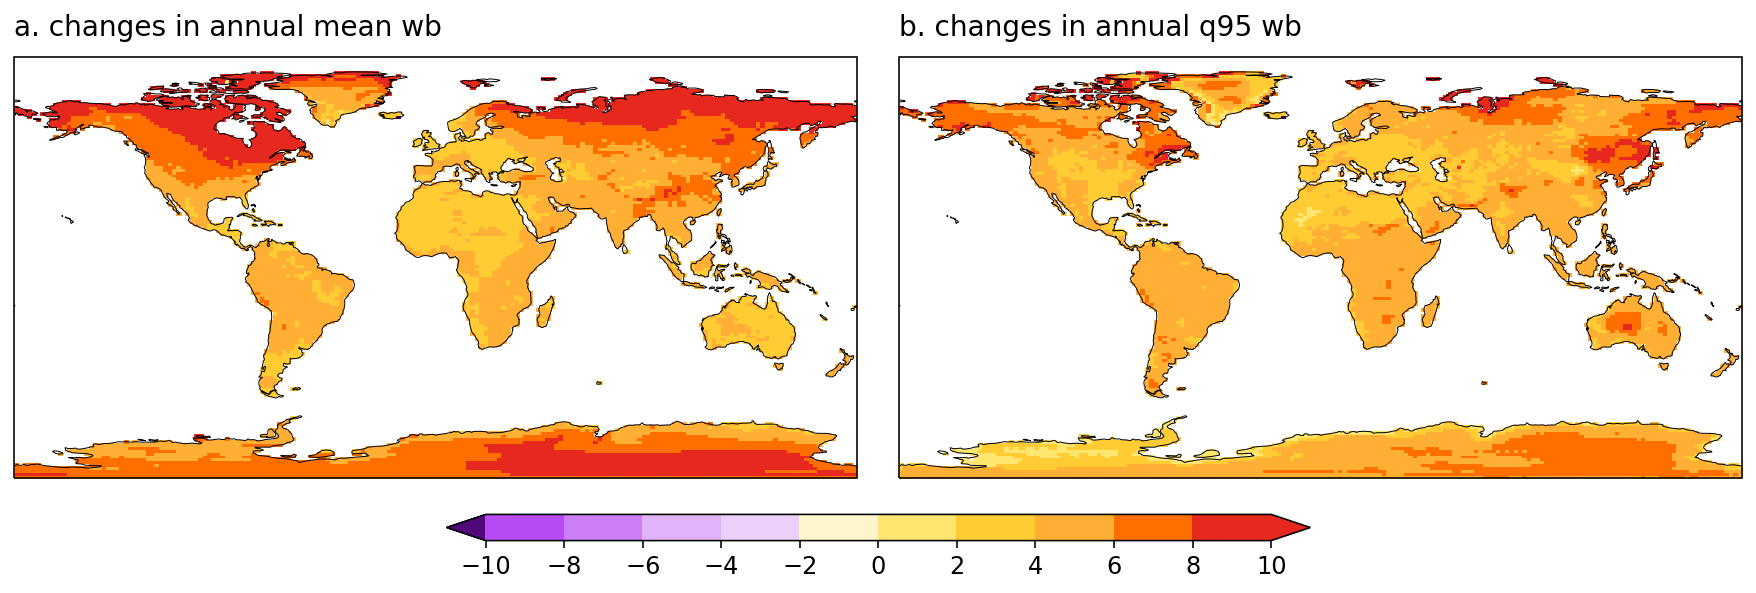

In [42]:
plot(diff)

### 2.5 What if we want subplots of different sizes?
GridSpec can enable us Customize subplots layouts

In [32]:
#plot a map
def Map(data,axis,norm,cmap):
    h=data.where(landmask==0).plot(ax=axis,transform=ccrs.PlateCarree(),add_colorbar=False,
                                                         norm=norm,cmap=cmap)
    gl=axis.gridlines(draw_labels=True,alpha=0)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.top_labels = False
    gl.right_labels = False
    axis.coastlines(alpha=0.6)
    return h
# line plot about zonal average
def lineplot(axis,x,y):
    axis.plot(x,y,linewidth=2,color='blue')
    axis.set_xlabel('change in wb ($^\circ$C)',fontsize=12)
    axis.set_ylabel('Latitude',fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.yaxis.set_ticks_position("right") # y axis ticks on the right
    axis.yaxis.set_label_position("right") # y axis labels on the right
def plot2(diff):
    levels=np.arange(-10, 10.1, 2)
    fig = plt.figure(figsize=(12,4))
    spec = gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[10,1],wspace=-0.1) # 2 columns with a width ratio of 10:1
    ax0 = fig.add_subplot(spec[0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(spec[1])
    anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    ax0.annotate('a. changes in annual mean wb', **anno_opts,fontsize=14)
    ax1.annotate('b', **anno_opts,fontsize=14)
    cmap=cmaps.sunshine_diff_12lev
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels)+1,extend='both')
    h=Map(diff.mean_diff,ax0,norm,cmap)
    cb=fig.colorbar(h,ax=ax0,orientation='vertical',ticks=levels,
                     pad=0.05,shrink=0.9)
    cb.ax.tick_params(labelsize=12)
    lineplot(ax1,diff.mean_diff.mean('lon'),diff.lat)

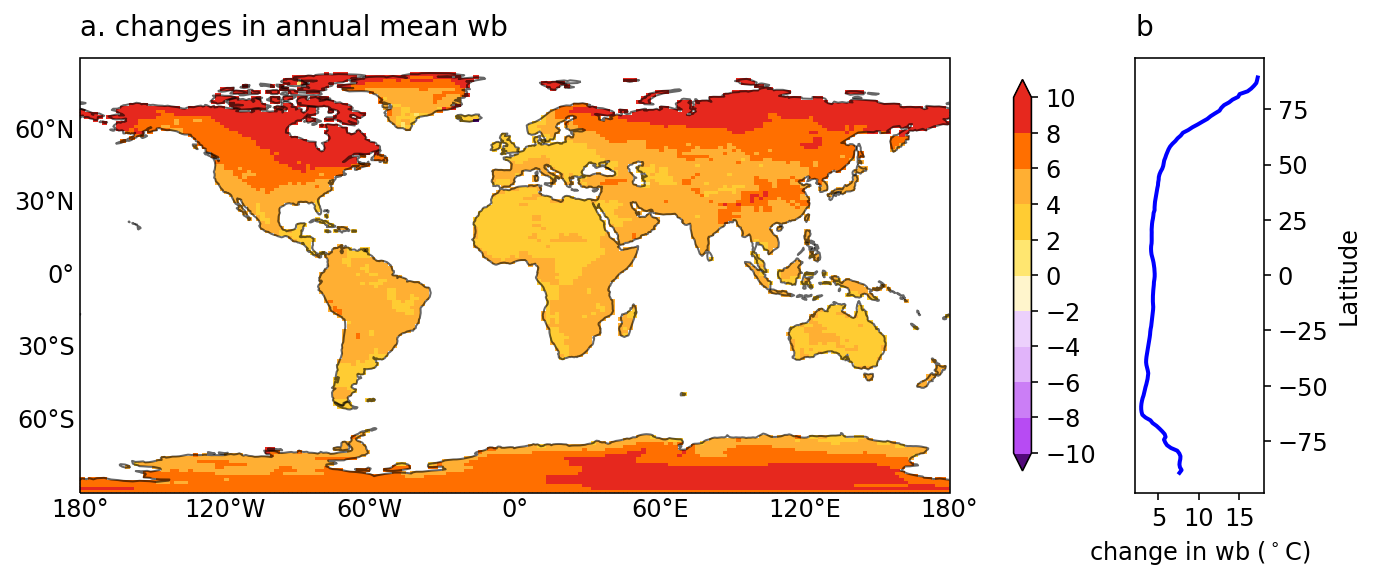

In [33]:
plot2(diff)

### 2.6 What if we want to overlay something on the map to for example show the statistical significance

we can use the contourf plot with hatches to achieve it.

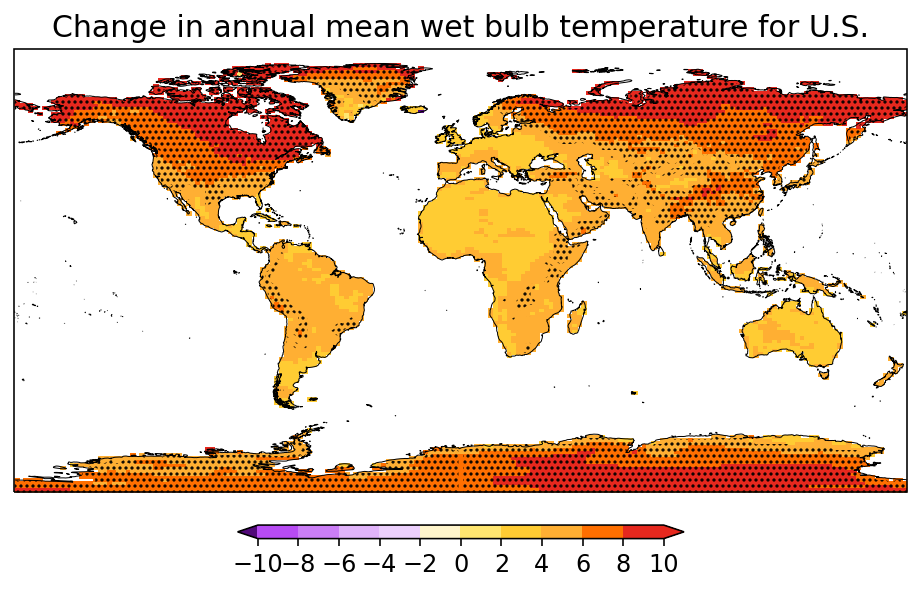

In [34]:
fig = plt.figure(figsize=[8, 6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m',linewidth=0.5)
levels=np.arange(-10, 10.1, 2)
cmap=cmaps.sunshine_diff_12lev
norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels)+1,extend='both')
temp = diff.mean_diff.where(landmask==0).plot(ax=ax,transform=ccrs.PlateCarree(),
                                              cmap=cmap,
                                              add_colorbar=False,norm=norm)
pvalue=xr.where(diff.mean_diff>5,0.01,0.09) # let's artificially create a p-value array

# add_cyclic_point can address the white line in the middle of the figure
#pvalue, lon = add_cyclic_point(pvalue, coord=pvalue.lon)
#pvalue=xr.DataArray(np.array(pvalue), dims=("lat", "lon"), coords={"lat": diff.lat,"lon":np.array(lon)})
#landmask2,lon2 = add_cyclic_point(landmask, coord=landmask.lon)
#landmask2=xr.DataArray(np.array(landmask2), dims=("lat", "lon"), coords={"lat": diff.lat,"lon":np.array(lon2)})

pvalue.where(landmask==0).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),
                     colors='none',
                     levels=[0,0.05,1],
                     hatches=['....',None],
                     add_colorbar=False,
                     alpha=0)
cb=plt.colorbar(temp,orientation='horizontal', pad=0.05,shrink=0.5,ticks=levels,aspect=30) 
cb.ax.tick_params(labelsize=12)

plt.title('Change in annual mean wet bulb temperature for U.S.', fontsize=15)
plt.show()

____________
## 3. Our final plot
____________

In [45]:
#plot a map
def Map(data,axis,norm,cmap,up):
    h=data.where(landmask==0).plot(ax=axis,transform=ccrs.PlateCarree(),add_colorbar=False,
                                   norm=norm,cmap=cmap)
    gl=axis.gridlines(draw_labels=True,alpha=0)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.top_labels = False
    gl.right_labels = False
    if up:
        gl.bottom_labels = False
    axis.coastlines(alpha=0.6)
    return h
# line plot for zonal average
def lineplot(axis,x,y,up):
    axis.plot(x,y,linewidth=2,color='blue')
    axis.set_xlabel('change in wb ($^\circ$C)',fontsize=12)
    axis.set_ylabel('Latitude',fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.yaxis.set_ticks_position("right") # y axis ticks on the right
    axis.yaxis.set_label_position("right") # y axis labels on the right
    if up:
        axis.set_xlabel('')
        axis.xaxis.set_ticklabels([])
def plot3(diff):
    levels=np.arange(-10, 10.1, 2)
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels)+1,extend='both')
    fig = plt.figure(figsize=(12,10))
    spec = gridspec.GridSpec(ncols=2, nrows=2,width_ratios=[10,1],hspace=0.2,wspace=-0.1) # 2 columns with a width ratio of 10:1
    ax0 = fig.add_subplot(spec[0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(spec[1])
    ax2 = fig.add_subplot(spec[2], projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(spec[3])
    anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    ax0.annotate('a. changes in annual mean wb', **anno_opts,fontsize=14)
    ax1.annotate('b', **anno_opts,fontsize=14)
    ax2.annotate('c. changes in annual q95 wb', **anno_opts,fontsize=14)
    ax3.annotate('d', **anno_opts,fontsize=14)
    cmap=cmaps.sunshine_diff_12lev
    h=Map(diff.mean_diff,ax0,norm,cmap,True)
    lineplot(ax1,diff.mean_diff.mean('lon'),diff.lat,True)
    Map(diff.q95_diff,ax2,norm,cmap,False)
    lineplot(ax3,diff.mean_diff.mean('lon'),diff.lat,False)
    cb=fig.colorbar(h,ax=(ax0,ax2),orientation='vertical',
                     pad=0.05,shrink=0.8,aspect=30)
    cb.ax.tick_params(labelsize=12)
    

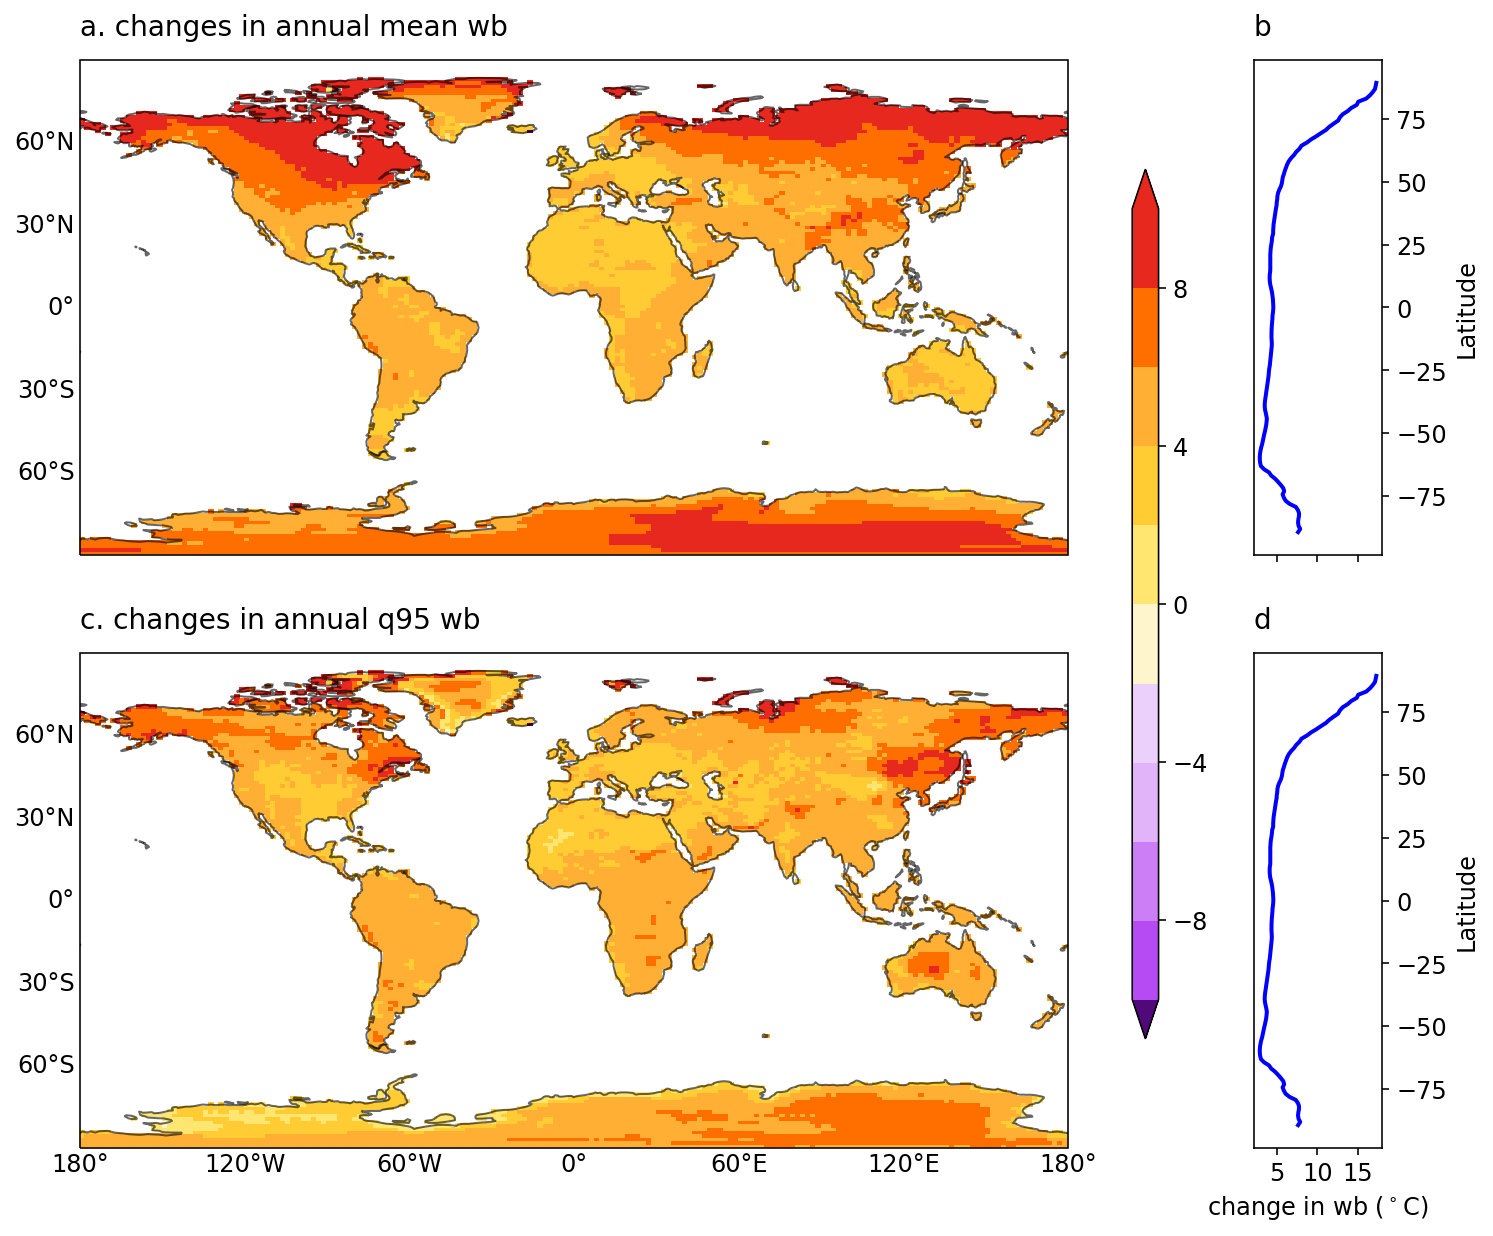

In [46]:
plot3(diff)
plt.savefig("./final_plot.pdf", bbox_inches='tight',dpi=400)